In [18]:
import pandas as pd
import numpy as np

def apply_laplace_privacy(data, epsilon):
    """
    Aplica el mecanismo de Laplace a una serie de Pandas para garantizar LDP.
    
    Parameters:
    data (pd.Series): Serie de valores numéricos a privatizar.
    epsilon (float): El presupuesto de privacidad, donde un epsilon más alto significa menos ruido.
    
    Returns:
    pd.Series: Serie de valores privatizados.
    """
    # Calcular la escala del ruido basado en el presupuesto de privacidad epsilon
    scale = 1 / epsilon
    
    # Generar ruido de Laplace para cada elemento en la serie
    noise = np.random.laplace(0, scale, size=len(data))
    
    # Añadir el ruido generado a los datos originales para obtener los datos privatizados
    privatized_data = data + noise
    
    return privatized_data

# Ejemplo de uso
# Supongamos que tienes un DataFrame con una columna de datos numéricos que quieres privatizar
data = {
    'age': [25, 30, 45, 50, 60]
}
df = pd.DataFrame(data)

# Definir el presupuesto de privacidad
epsilon = 0.6

# Aplicar la privatización de Laplace a la columna 'age'
df['age_privatized'] = apply_laplace_privacy(df['age'], epsilon)
print(df)


   age  age_privatized
0   25       25.004735
1   30       29.377681
2   45       44.678314
3   50       46.016594
4   60       58.577253


In [45]:
import pandas as pd
import numpy as np

def apply_oue_privacy(data, categories, epsilon):
    """
    Aplica la Codificación Unaria Optimizada (OUE) a una serie de datos categóricos en Pandas para garantizar LDP.
    
    Parameters:
    data (pd.Series): Serie de datos categóricos a privatizar.
    categories (list): Lista de todas las categorías posibles en los datos.
    epsilon (float): El presupuesto de privacidad, donde un epsilon más alto significa menos ruido.
    
    Returns:
    pd.DataFrame: DataFrame donde cada columna representa una categoría, con datos privatizados binariamente.
    """
    n = len(categories)
    p = 1 / 2 + np.exp(epsilon) / (2 * (np.exp(epsilon) + 1))

    # Crear un DataFrame vacío con columnas para cada categoría
    noisy_df = pd.DataFrame(0, index=data.index, columns=categories)

    # Aplicar ruido a cada categoría según el método OUE
    for category in categories:
        is_category = (data == category).astype(int)
        noisy_df[category] = is_category.apply(lambda x: np.random.binomial(1, p if x == 1 else 1 - p))

    return noisy_df

# Ejemplo de uso
# Supongamos que tienes un DataFrame con una columna de datos categóricos que quieres privatizar
data = {
    'fruit': ['apple', 'banana', 'apple', 'cherry', 'banana']
}
df = pd.DataFrame(data)

# Lista de todas las categorías posibles
categories = ['apple', 'banana', 'cherry']

# Definir el presupuesto de privacidad
epsilon = 1.0

# Aplicar la privatización OUE a la columna 'fruit'
df_privatized = apply_oue_privacy(df['fruit'], categories, epsilon)
print(df_privatized)

   apple  banana  cherry
0      0       0       0
1      1       0       0
2      1       0       0
3      0       0       0
4      1       1       0


In [46]:
df

,fruit
0,apple
1,banana
2,apple
3,cherry
4,banana


In [17]:
import pandas as pd
import numpy as np

def apply_duchi_privacy(data, epsilon):
    """
    Aplica el mecanismo de Duchi et al. a una serie de Pandas para LDP.
    Los datos se normalizan automáticamente al rango [-1, 1], se aplica el mecanismo, y luego se desnormalizan al rango original.
    
    Parameters:
    data (pd.Series): Serie de valores numéricos a privatizar.
    epsilon (float): El presupuesto de privacidad.
    
    Returns:
    pd.Series: Serie de valores privatizados, ajustados al rango original de los datos.
    """
    # Normalizar datos al rango [-1, 1]
    min_val = data.min()
    max_val = data.max()
    normalized_data = 2 * ((data - min_val) / (max_val - min_val)) - 1

    # Aplicar Duchi et al.
    b = np.exp(epsilon + 1) / np.exp(epsilon - 1)
    probabilities = (np.exp(epsilon) - 1) / (2 * np.exp(epsilon) + 2) * normalized_data + 0.5
    privatized_normalized_data = pd.Series(np.where(np.random.rand(len(data)) < probabilities, b, -b), index=data.index)

    # Desnormalizar datos al rango original
    privatized_data = (privatized_normalized_data + 1) / 2 * (max_val - min_val) + min_val
    
    return privatized_data

# Ejemplo de uso
data = pd.Series([25, 30, 45, 50, 60])
epsilon = 0.6

# Aplicar la privatización de Duchi
df['age_privatized'] = apply_duchi_privacy(df['age'], epsilon)
print(df)

   age  age_privatized
0   25      171.808482
1   30      171.808482
2   45      171.808482
3   50      171.808482
4   60      -86.808482


In [25]:
import pandas as pd
import numpy as np

def apply_piecewise_mechanism(data, epsilon):
    """
    Aplica el Mecanismo Pieza por Pieza (PM) a una serie de Pandas para LDP.
    Los datos deben estar en el rango [-1, 1] y la salida será en el rango [-C, C].
    
    Parameters:
    data (pd.Series): Serie de valores numéricos en el rango [-1, 1] a privatizar.
    epsilon (float): El presupuesto de privacidad.
    
    Returns:
    pd.Series: Serie de valores privatizados en el rango [-C, C].
    """
    # Calcular el valor de C
    C = (np.exp(epsilon / 2) + 1) / (np.exp(epsilon / 2) - 1)
    
    # Calcular la probabilidad p
    p = (np.exp(epsilon) - np.exp(epsilon / 2)) / (2 * np.exp(epsilon / 2) + 2)
    
    # Inicializar la serie privatizada
    privatized_data = pd.Series(index=data.index)
    
    # Aplicar el mecanismo a cada entrada
    for i in data.index:
        # Calcular los límites `(ti)` y `r(ti)`
        l = C + 0.5 * data[i] - 0.5 * (C - 1)
        r = l + (C - 1)
        
        # Determinar la región a partir de la cual muestrear
        if np.random.random() < p:
            # Muestrear de la región central
            privatized_data[i] = np.random.uniform(l, r)
        else:
            # Muestrear de las regiones laterales
            if np.random.random() < 0.5:
                privatized_data[i] = np.random.uniform(-C, l)
            else:
                privatized_data[i] = np.random.uniform(r, C)
    
    return privatized_data

# Ejemplo de uso
data = {
    'age': [25, 30, 45, 50, 60]
}
df = pd.DataFrame(data)

# Definir el presupuesto de privacidad
epsilon = 0.6

# Aplicar la privatización Piecewise a la columna 'normalized_values'
df['age_privatized'] = apply_piecewise_privacy(df['age'], epsilon)
print(df)


   age  age_privatized
0   25       16.627975
1   30       72.085944
2   45       35.827362
3   50      103.674458
4   60      208.268145


In [19]:
import pandas as pd
import numpy as np

def apply_hybrid_privacy(data, epsilon):
    """
    Aplica el mecanismo híbrido (HM) a una serie de Pandas, combinando los mecanismos de Duchi et al. y PM.
    Asume que los datos ya están normalizados en el rango [-1, 1].
    
    Parameters:
    data (pd.Series): Serie de valores numéricos en el rango [-1, 1] a privatizar.
    epsilon (float): El presupuesto de privacidad.
    
    Returns:
    pd.Series: Serie de valores privatizados.
    """
    # Parámetros para los mecanismos de Duchi et al. y PM
    b = np.exp(epsilon + 1) / np.exp(epsilon - 1)
    C = (np.exp(epsilon / 2) + 1) / (np.exp(epsilon / 2) - 1)
    alpha = 1 - np.exp(-epsilon / 2)  # Probabilidad de elegir PM sobre Duchi

    # Inicializar la serie privatizada
    privatized_data = pd.Series(index=data.index)

    # Aplicar el mecanismo híbrido
    for i in data.index:
        if np.random.random() < alpha:
            # Mecanismo Pieza por Pieza (PM)
            l = C + (data[i] - 1) / 2
            r = l + (C - 1)
            if np.random.random() < (np.exp(epsilon) - np.exp(epsilon / 2)) / (2 * np.exp(epsilon / 2) + 2):
                privatized_data[i] = np.random.uniform(l, r)
            else:
                privatized_data[i] = np.random.choice([np.random.uniform(-C, l), np.random.uniform(r, C)])
        else:
            # Mecanismo de Duchi
            probability = (np.exp(epsilon) - 1) / (2 * np.exp(epsilon) + 2) * data[i] + 0.5
            privatized_data[i] = b if np.random.random() < probability else -b

    return privatized_data

# Ejemplo de uso con datos normalizados
data = {
    'age': [25, 30, 45, 50, 60]
}
df = pd.DataFrame(data)
epsilon = 0.6

df['age_privatized'] = apply_hybrid_privacy(df['age'], epsilon)
print(df)


   age  age_privatized
0   25        7.389056
1   30        7.389056
2   45        7.389056
3   50        7.389056
4   60        7.389056


# Comparación 

In [26]:
import pandas as pd
import numpy as np

# Generar datossimulados
np.random.seed(42)  # Para reproducibilidad
data = pd.DataFrame({
    'age': np.random.randint(18, 70, size=1000)  # 1000 edades entre 18 y 70
})

# Normalizar los datos para Duchi, PM, y HM
data['normalized_age'] = 2 * ((data['age'] - data['age'].min()) / (data['age'].max() - data['age'].min())) - 1


In [27]:
data.head()

,age,normalized_age
0,56,0.490196
1,69,1.000000
2,46,0.098039
3,32,-0.450980
4,60,0.647059


In [33]:
epsilon = 0.1  # Nivel de privacidad

# Aplicar los métodos
data['age_laplace'] = apply_laplace_privacy(data['age'], epsilon)
data['age_duchi'] = apply_duchi_privacy(data['normalized_age'], epsilon)  # Asumiendo que apply_duchi_privacy maneja la desnormalización internamente si necesario
data['age_pm'] = apply_piecewise_privacy(data['normalized_age'], epsilon)  # Asumiendo una función adecuada
data['age_hm'] = apply_hybrid_privacy(data['normalized_age'], epsilon)  # Asumiendo una función adecuada


In [34]:
data.head()

,age,normalized_age,age_laplace,age_duchi,age_pm,age_hm
0,56,0.490196,64.104920,-7.389056,37.572017,7.389056
1,69,1.000000,75.493270,-7.389056,-14.663392,7.389056
2,46,0.098039,61.414484,7.389056,-25.368342,-7.389056
3,32,-0.450980,30.900593,-7.389056,-34.528253,-7.389056
4,60,0.647059,60.628827,-7.389056,35.783951,7.389056


MSE Laplace: 218.40605444976694
MSE Duchi: 2205.9923035319625
MSE PM: 2841.34937319634
MSE HM: 2133.2901239075195


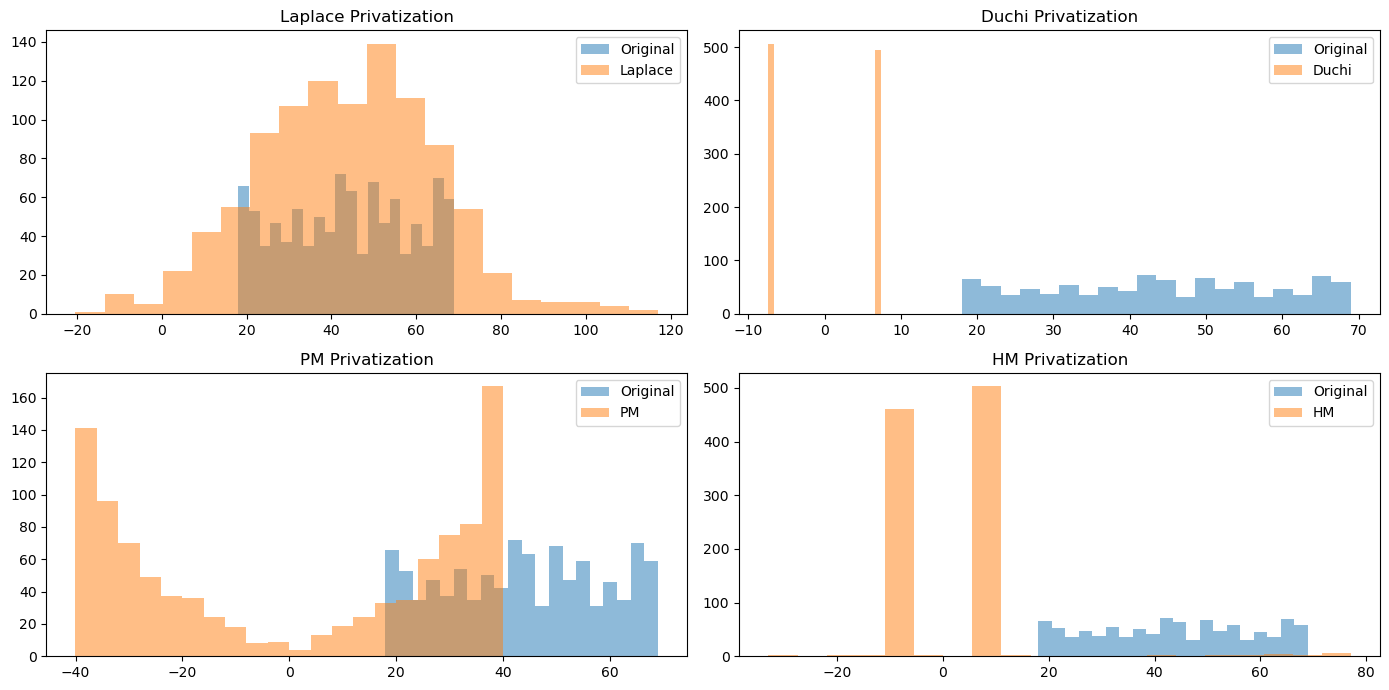

In [35]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calcular MSE
mse_laplace = mean_squared_error(data['age'], data['age_laplace'])
mse_duchi = mean_squared_error(data['age'], data['age_duchi'])
mse_pm = mean_squared_error(data['age'], data['age_pm'])
mse_hm = mean_squared_error(data['age'], data['age_hm'])

print(f"MSE Laplace: {mse_laplace}")
print(f"MSE Duchi: {mse_duchi}")
print(f"MSE PM: {mse_pm}")
print(f"MSE HM: {mse_hm}")

# Gráfico de histogramas para comparar la distribución
plt.figure(figsize=(14, 7))
plt.subplot(221)
plt.hist(data['age'], bins=20, alpha=0.5, label='Original')
plt.hist(data['age_laplace'], bins=20, alpha=0.5, label='Laplace')
plt.legend()
plt.title('Laplace Privatization')

plt.subplot(222)
plt.hist(data['age'], bins=20, alpha=0.5, label='Original')
plt.hist(data['age_duchi'], bins=20, alpha=0.5, label='Duchi')
plt.legend()
plt.title('Duchi Privatization')

plt.subplot(223)
plt.hist(data['age'], bins=20, alpha=0.5, label='Original')
plt.hist(data['age_pm'], bins=20, alpha=0.5, label='PM')
plt.legend()
plt.title('PM Privatization')

plt.subplot(224)
plt.hist(data['age'], bins=20, alpha=0.5, label='Original')
plt.hist(data['age_hm'], bins=20, alpha=0.5, label='HM')
plt.legend()
plt.title('HM Privatization')

plt.tight_layout()
plt.show()


In [36]:
import numpy as np
import pandas as pd

class DuchiMechanism:
    def __init__(self, epsilon, domain=(-1, 1)):
        self._epsilon = epsilon
        self._domain = domain
        self._p = np.exp(epsilon) / (np.exp(epsilon) + 1)

    def _check_value(self, value):
        if not self._domain[0] <= value <= self._domain[1]:
            raise ValueError(f"ERR: The input value={value} is not in the input domain={self._domain}.")
        return value

    def randomize(self, value):
        value = self._check_value(value)
        a, b = self._domain
        rnd_p = ((1-2*self._p)*value + (a*self._p + b*self._p - a)) / (b - a)
        rnd = np.random.random()
        value = a if rnd <= rnd_p else b
        value = (value - (b + a) * (1 - self._p)) / (2 * self._p - 1)
        return value

    def apply_to_series(self, series):
        return series.apply(self.randomize)

def apply_duchi_to_dataframe(df, column_name, epsilon):
    duchi = DuchiMechanism(epsilon=epsilon, domain=(df[column_name].min(), df[column_name].max()))
    df[column_name + '_duchi'] = duchi.apply_to_series(df[column_name])
    return df

# Usage example
if __name__ == '__main__':
    # Create a DataFrame with example data
    df = pd.DataFrame({
        'values': np.random.uniform(-1, 1, size=1000)
    })
    epsilon = 0.5
    df = apply_duchi_to_dataframe(df, 'values', epsilon)
    print(df.head())


     values  values_duchi
0 -0.013609     -4.081182
1 -0.402822     -4.081182
2 -0.682070      4.081651
3 -0.905300     -4.081182
4 -0.608043      4.081651


In [37]:
import scipy.stats as stats
from scipy.special import comb
import numpy as np
from datetime import datetime
import json
from time import process_time


def Delta(ep, alpha, r0, r1, n, p, tol=1e-12):
    rate = r0/(r0+r1)

    def fvlow(c):
        # vectorized computation for a list of c (required by scipy.stats.rv_discrete.expect)
        g01 = (1-alpha-alpha*p)*(n-(c+1))/(1-r0-r1)
        low01 = ((np.exp(ep)*p-1)*alpha*(c+1)/r1+(np.exp(ep)-1)*g01)/(alpha*(p/r0-1/r1+np.exp(ep)*(p/r1-1/r0)))
        g2 = (1-alpha-alpha*p)*(n-c)/(1-r0-r1)
        low2 = ((np.exp(ep)*p-1)*alpha*c/r1+(np.exp(ep)-1)*g2)/(alpha*(p/r0-1/r1+np.exp(ep)*(p/r1-1/r0)))

        v0 = np.array([1-stats.binom.cdf(int(np.ceil(low01[i]))-2, c[i], rate) for i in range(len(c))])
        v1 = np.array([1-stats.binom.cdf(int(np.ceil(low01[i]))-1, c[i], rate) for i in range(len(c))])
        v2 = np.array([1-stats.binom.cdf(int(np.ceil(low2[i]))-1, c[i], rate) for i in range(len(c))])

        # linear transformation (and weights are independent from c)
        p0 = p*alpha*v0+alpha*v1+(1-alpha-p*alpha)*v2
        p1 = alpha*v0+p*alpha*v1+(1-alpha-p*alpha)*v2
        return p0-np.exp(ep)*p1

    def fvhigh(c):
        g01 = (1-alpha-alpha*p)*(n-(c+1))/(1-r0-r1)
        high01 = ((np.exp(-ep)*p-1)*alpha*(c+1)/r1+(np.exp(-ep)-1)*g01)/(alpha*(p/r0-1/r1+np.exp(-ep)*(p/r1-1/r0)))
        g2 = (1-alpha-alpha*p)*(n-c)/(1-r0-r1)
        high2 = ((np.exp(-ep)*p-1)*alpha*c/r1+(np.exp(-ep)-1)*g2)/(alpha*(p/r0-1/r1+np.exp(-ep)*(p/r1-1/r0)))

        v0 = np.array([stats.binom.cdf(int(np.floor(high01[i]-1)), c[i], rate) for i in range(len(c))])
        v1 = np.array([stats.binom.cdf(int(np.floor(high01[i])), c[i], rate) for i in range(len(c))])
        v2 = np.array([stats.binom.cdf(int(np.floor(high2[i])), c[i], rate) for i in range(len(c))])

        p0 = p*alpha*v0+alpha*v1+(1-alpha-p*alpha)*v2
        p1 = alpha*v0+p*alpha*v1+(1-alpha-p*alpha)*v2
        return p1-np.exp(ep)*p0

    delta0 = stats.binom.expect(fvlow, args=(n-1, r0+r1), lb=0, ub=n-1, tolerance=tol, maxcount=n, chunksize=32)
    if r0 == r1:
        # by the symmetry of r0 and r1, delta0 always equals to delta1
        delta1 = delta0
    else:
        delta1 = stats.binom.expect(fvhigh, args=(n-1, r0+r1), lb=0, ub=n-1, tolerance=tol, maxcount=n, chunksize=32)
    #print("delta01", delta0, delta1)

    return max(delta0, delta1)


def amplificationUB(p, beta, q0, q1, n, delta, T):
    # privacy amplification upper bound
    alpha = beta/(p-1)
    r0 = alpha*p/q0
    r1 = alpha*p/q1
    return amplificationUBCore(p, alpha, r0, r1, n, delta, T)


def amplificationUBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p) # one may also use the closed-form bound as a starting point

    # tolerance in scipy.stats.rv_discrete.expect
    tol = max(1e-19, min(1e-14, delta/n/10.0))
    for t in range(T):
        ep = (epL+epH)/2.0
        # add tol*n to delta, extremely conservative for rigidness, one may modify the scipy.stats.rv_discrete.expect to get tighter bounds
        if Delta(ep, alpha, r0, r1, n, p, tol)+tol*n   > delta:
            epL = ep
        else:
            epH = ep
    return epH


def amplificationLB(p, beta, q0, q1, n, delta, T):
    # privacy amplification lower bound
    alpha = beta/(p-1)
    r0 = alpha*p/q0
    r1 = alpha*p/q1
    return amplificationLBCore(p, alpha, r0, r1, n, delta, T)


def amplificationLBCore(p, alpha, r0, r1, n, delta, T):
    epL = 0
    epH = np.log(p)

    # tolerance in scipy.stats.rv_discrete.expect
    tol = max(1e-19, min(1e-14, delta/n/10.0))
    for t in range(T):
        ep = (epL+epH)/2.0
        # there is no tol*n, as scipy.stats.rv_discrete.expect always underestimate non-negative delta
        if Delta(ep, alpha, r0, r1, n, p, tol) > delta:
            epL = ep
        else:
            epH = ep
    return epL


def computeUBParameters(epsilon, mechanism, options):
    # variation-ratio parameters for upper bounds
    p = np.exp(epsilon)
    beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+1)
    q = np.exp(epsilon)
    if mechanism in ['laplace']:
        beta = 1-np.exp(-epsilon/2)
    elif mechanism in ['piecewise']:
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+np.exp(epsilon/2))
    elif mechanism in ['krr']:
        k = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+k-1)
    elif mechanism in ['subset']:
        d, k = options[0], options[1]
        beta = (np.exp(epsilon)-1)*(comb(d-1, k-1)-comb(d-2, k-2))/(np.exp(epsilon)*comb(d-1, k-1)+comb(d-1, k))
    elif mechanism in ['localhash']:
        l = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+l-1)
    elif mechanism in ['hardamard']:
        K, s = options[0], options[1]
        beta = (s*(np.exp(epsilon)-1)/2)/(s*np.exp(epsilon)+K-s)
    elif mechanism in ['hardamardB']:
        K, s = options[0], options[1]
        beta = (s*(np.exp(epsilon)-1))/(s*np.exp(epsilon)+K-s)
    elif mechanism in ['collision']:
        if hasattr(options, '__iter__'):
            s, l = options[0], options[1]
        else:
            s = options
            l = int(s*np.exp(epsilon)+2*s-1)
        beta = s*(np.exp(epsilon)-1)/(s*np.exp(epsilon)+l-s)
    elif mechanism in ['cheu']:
        m, epc, deltac = options[0], options[1], options[2]
        right = 33.0/5*(((np.exp(epc)+1)/(np.exp(epc)-1))**2)*np.log(4/deltac)
        assert m*m-4*m*right >= 0
        f = (m-np.sqrt(m*m-4*m*right))/(2*m) # the p in the original paper
        #print("mechanism", mechanism, m, 4*right, f)
        f = min(1/2-0.00000001, f)
        p = (1-f)**2/(f*f)
        beta = 1-2*f
        q = (1-f)/f
    elif mechanism in ['balls2bins']:
        d, s = options[0], options[1]
        p = 10**5  # simulate +inf
        beta = (p-1)/(p+1)
        q = d/s
    elif mechanism in ['krr_sep_best']:
        k = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+k-1)
    elif mechanism in ['krr_sep_worst']:
        k = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+2-1)
    elif mechanism in ['krr_para_basic']:
        k = int(options)
        beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+1)
    elif mechanism in ['krr_para_advanced']:
        k = int(options)
        beta = 0
        for h in range(int(np.log2(k))):
            beta = (np.exp(epsilon)-1)/(np.exp(epsilon)+2**(h+1)-1)/int(np.log2(k))
    return p, beta, q, q



if __name__ == '__main__':
    epsilons = np.array([0.1, 1.0, 3.0, 5.0]) # local epsilon for single-message protocols
    #epsilons = np.array([1.0, 2.0, 3.0, 4.0])
    #epsilons = np.arange(0.01, 1.02, 0.03) # global epsilon for multi-message protocols


    #ms = [None] # general LDP mechanisms
    ms = [None, "laplace", "piecewise", "krr", "subset", "localhash", "hardamard", "hardamardB", "collision"]
    #ms = [None, "collision"]
    #ms = ["krr_para_advanced", "krr_para_basic", "krr_sep_best", "krr_sep_worst"] # range queries with krr
    #ms = ["cheu", "balls2bins"] # multi-message protocols

    #bounds = ["variation_ratio", "variation_ratio_closed", "variation_ratio_tightclosed", "strong_clone", "strong_clone_closed", "clone", "clone_closed",
    #"erlingsson", "erlingsson_closed", "blanket_hoeffding", "blanket_bennett", "blanket_hoeffding_generic", "blanket_bennett_generic"]
    bounds = ["variation_ratio", "variation_ratio_closed", "variation_ratio_tightclosed", "strong_clone", "strong_clone_closed", "clone_closed"]
    #bounds = ["variation_ratio", "variation_ratio_tightclosed", "variation_ratio_closed"]

    # the dict for recording amplification settings/results
    results = {}
    results["epsilons"] = epsilons.tolist()
    results["ms"] = ms

    n = 1000000
    nusers = n
    delta = 0.01/n
    # number of binary search iterations
    T = 12

    d = 100 # 64, 2048, domain size
    s = 8 # sparsity parameter for set-valued data or key-value data
    results["n"] = n
    results["delta"] = delta
    results["d"] = d
    print("epsilons, n, ms, d, s", epsilons, n, ms, (d,s))
    print("bounds", bounds)

    #filename = "unified_n"+str(n)+"_d"+str(d)+"_s"+str(s)+".json"
    filename = None  # None means don't save results to disk

    for epsilon in epsilons:
        # for single-message
        options = [None, None, None, d, (d, int(np.ceil(d/(np.exp(epsilon)+0)))), int(np.exp(epsilon)+1), (d, d/2), (d, d/2, 8), (s, int(s*np.exp(epsilon)+2*s-1))]
        #options = [None, s]

        # for range query with parallel composition on krr
        #options = [d, d, d, d]

        # for multi-message protocol
        #options = [(n, epsilon, delta), (d, s)] # options for multi-message protocols

        for mi, m in enumerate(ms):
            if m in ["balls2bins"]:
                d, s = options[mi][0], options[mi][1]
                n = int(32*np.log(2/delta)*d/s/(epsilon*epsilon)) # number of covering messages
                print(m, n, d, s)
            elif m in ['krr_sep_best', 'krr_sep_worst']:
                d = int(options[mi])
                n = int(n/np.log2(d)) # separating into sub-populations for each hierarchy
            else:
                n = nusers

            if results.get(m) is None:
                results[m] = {}
                for bound in bounds:
                    results[m][bound] = []
            if "variation_ratio" in bounds:
                p, beta, q0, q1 = computeUBParameters(epsilon=epsilon, mechanism=ms[mi], options=options[mi])
                start = process_time()
                ub = amplificationUB(p, beta, q0, q1, n, delta, T)
                end = process_time()

                results[m]["variation_ratio"].append(ub)
                #print running time
                print("running time: m, epsilon, n, process time", m, epsilon, n, end-start)
                #results[m]["time_variation_ratio"].append(end-start)

            if "variation_ratio_closed" in bounds:
                p, beta, q0, q1 = computeUBParameters(epsilon=epsilon, mechanism=ms[mi], options=options[mi])
                q = max(q0, q1)
                r = beta*p/((p-1)*q)
                aub1 = epsilon
                if n > 8*np.log(4/delta)/r:
                    c = max(0, 4*(1-3*r)/(9*(1-2*r)))
                    aub1 = np.log(1+beta/((1-c)*(1+p)*beta/(p-1)+c)*(np.sqrt(32*np.log(4/delta)/(r*(n-1)))+4/(r*(n-1))))
                results[m]["variation_ratio_closed"].append(aub1)

            if "variation_ratio_tightclosed" in bounds:
                p, beta, q0, q1 = computeUBParameters(epsilon=epsilon, mechanism=ms[mi], options=options[mi])
                q = max(q0, q1)
                alpha = beta/(p-1)
                r = alpha*p/q
                aubx = epsilon
                Omega = (n-1)*(2*r)-np.sqrt(min(6*r,1/2)*(n-1)*np.log(4/delta))
                if Omega > 0 and (p+1)*alpha/2-(1-alpha-alpha*p)*r/(1-2*r) > 0.0 and Omega > (2*p*(beta+1+(beta-1)*p)*(n-1)+beta)/(q+p*(beta-1+(beta+1)*p)-p*q):
                    alpha = beta/(p-1)
                    aubx = np.log(1+beta*(2*np.sqrt(Omega*np.log(4/delta)/2)+1)/(alpha*Omega+beta*(Omega/2-np.sqrt(Omega*np.log(4/delta)/2))+(1-alpha-alpha*p)*(n-1-Omega)*r/(1-2*r)))
                results[m]["variation_ratio_tightclosed"].append(aubx)

            if "strong_clone" in bounds:
                p = np.exp(epsilon)
                alpha = 1.0/(np.exp(epsilon)+1)
                r = 1.0/(np.exp(epsilon)+1)
                ub_sc = amplificationUBCore(p, alpha, r, r, n, delta, T)
                results[m]["strong_clone"].append(ub_sc)

            if "strong_clone_closed" in bounds:
                alpha = 1.0/(np.exp(epsilon)+1)
                r = 1.0/(np.exp(epsilon)+1)
                aub2 = epsilon
                if n > 8*np.log(4/delta)/r:
                    aub2 = np.log(1+(np.exp(epsilon)-1)/(np.exp(epsilon)+1)*(np.sqrt(32*np.log(4/delta)/(r*(n-1)))+4/(r*(n-1))))
                results[m]["strong_clone_closed"].append(aub2)

            # clone reduction, Vitaly Feldman, Audra McMillan, and Kunal Talwar. Hiding among the clones: A simple and nearly optimal analysis of privacy amplification by shuffling. In 2021 IEEE 62nd Annual Symposium on Foundations of Computer Science (FOCS), pages 954–964. IEEE, 202
            # for comparison with numerical clone, download https://github.com/apple/ml-shuffling-amplification/
            """
            if "clone" in bounds:
                import computeamplification as CA
                r = 1.0/(2*np.exp(epsilon))
                ub_c = CA.numericalanalysis(n, 2*r, epsilon, delta, T, 10, True, coin=1/2, factor=1.0)[1]
                results[m]["clone"].append(ub_c)
            """

            if "clone_closed" in bounds:
                r = 1.0/(2*np.exp(epsilon))
                aub3 = epsilon
                if n > 8*np.log(4/delta)/r:
                    aub3 = np.log(1+(np.exp(epsilon)-1)/(np.exp(epsilon)+1)*(np.sqrt(32*np.log(4/delta)/(r*(n-1)))+4/(r*(n-1))))
                results[m]["clone_closed"].append(aub3)

            # privacy blanket, B. Balle, J. Bell, A. Gascon, and K. Nissim. The Privacy Blanket of the Shuffle Model, International Cryptology Conference (CRYPTO), 2019
            # for comparison with numerical privacy blanket, download https://github.com/BorjaBalle/amplification-by-shuffling
            """
            import shuffleddp
            from shuffleddp.amplification_bounds import *
            from shuffleddp.mechanisms import *
            if shuffleddp is not None and len({"erlingsson_closed", "blanket_hoeffding", "blanket_bennett", "blanket_hoeffding_generic", "blanket_bennett_generic"}.intersection(set(bounds))) > 0:
                blanketname = m
                if m in ["collision"]:
                    blanketname += str(options[mi])
                mks = [LDPMechanism(eps0=epsilon, name=blanketname), LDPMechanism(eps0=epsilon, name="generic")]

                # This bound does not use infomation about the underlying mechanism
                erlingsson = Erlingsson()
                all_bounds = [erlingsson]

                # The other two bounds can use a 'Generic' mechanism or a specific mechanism
                bound_types = [Hoeffding, BennettExact]
                for mk in mks:
                    for B in bound_types:
                        all_bounds.append(B(mk))
                epcbounds = []
                for bi, b in enumerate(all_bounds):
                    epc = b.get_eps(epsilon, n, delta)
                    epcbounds.append(epsilon if math.isnan(epc) else epc)

                results[m]["erlingsson_closed"].append(epcbounds[0])
                results[m]["blanket_hoeffding"].append(epcbounds[1])
                results[m]["blanket_bennett"].append(epcbounds[2])
                results[m]["blanket_hoeffding_generic"].append(epcbounds[3])
                results[m]["blanket_bennett_generic"].append(epcbounds[4])
            """

            print(epsilon, m, [results[m][bound][-1] for bound in bounds],  options[mi])

    if filename is not None:
        with open(datetime.now().isoformat().replace(':', '_')+'-'+filename, 'w') as outfile:
            json.dump(results, outfile)

epsilons, n, ms, d, s [0.1 1.  3.  5. ] 1000000 [None, 'laplace', 'piecewise', 'krr', 'subset', 'localhash', 'hardamard', 'hardamardB', 'collision'] (100, 8)
bounds ['variation_ratio', 'variation_ratio_closed', 'variation_ratio_tightclosed', 'strong_clone', 'strong_clone_closed', 'clone_closed']
running time: m, epsilon, n, process time None 0.1 1000000 1.532064
0.1 None [0.00036621093750000027, 0.0018236450545974885, 0.0006463721840806797, 0.00036621093750000027, 0.0018236450545974885, 0.0018686116693376169] None
running time: m, epsilon, n, process time laplace 0.1 1000000 1.732845000000001
0.1 laplace [0.00036621093750000027, 0.0018457035384993508, 0.0006379572206116966, 0.00036621093750000027, 0.0018236450545974885, 0.0018686116693376169] None
running time: m, epsilon, n, process time piecewise 0.1 1000000 1.7576269999999994
0.1 piecewise [0.00036621093750000027, 0.0018457035384993508, 0.0006379572206116966, 0.00036621093750000027, 0.0018236450545974885, 0.0018686116693376169] None

KeyboardInterrupt: 

In [39]:
import numpy as np
import pandas as pd
from scipy.stats import laplace

# Función para normalizar datos
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Mecanismo de Laplace
def apply_laplace(data, epsilon):
    scale = 1/epsilon
    noise = laplace.rvs(scale=scale, size=data.size)
    return data + noise

# Mecanismo de Duchi
def apply_duchi(data, epsilon):
    C = (np.exp(epsilon) + 1) / (np.exp(epsilon) - 1)
    perturbed_data = np.random.choice([-C, C], p=[0.5, 0.5], size=data.size)
    return perturbed_data

# Mecanismo de Piecewise (simplificado para demostración)
def apply_piecewise(data, epsilon):
    C = (np.exp(epsilon/2) + 1) / (np.exp(epsilon/2) - 1)
    perturbed_data = np.random.choice([-C, C], size=data.size)
    return perturbed_data

# Mecanismo de Subset Selection (corregido)
def apply_subset_selection(data, epsilon, k=2):
    data = normalize(data) * (k-1)
    subsets = [np.random.choice(range(k), p=[np.exp(epsilon)/ (np.exp(epsilon) + k - 1) if i == int(v) else 1 / (np.exp(epsilon) + k - 1) for i in range(k)]) for v in data]
    return subsets

# Mecanismo híbrido de ejemplo (Laplace + Duchi)
def apply_hybrid(data, epsilon):
    laplace_data = apply_laplace(data, epsilon)
    duchi_data = apply_duchi(data, epsilon)
    return (laplace_data + duchi_data) / 2

# Crear DataFrame
np.random.seed(0)
df = pd.DataFrame({'age': np.random.randint(18, 65, size=100)})

# Aplicar mecanismos
epsilon = 0.5
df['laplace'] = apply_laplace(df['age'], epsilon)
df['duchi'] = apply_duchi(df['age'], epsilon)
df['piecewise'] = apply_piecewise(df['age'], epsilon)
df['subset'] = apply_subset_selection(df['age'], epsilon)
df['hybrid'] = apply_hybrid(df['age'], epsilon)

print(df.head())



   age    laplace     duchi  piecewise  subset     hybrid
0   62  54.786748  4.082988  -8.041623       1  32.757078
1   18  18.563910  4.082988  -8.041623       1  11.023380
2   21  21.853334  4.082988  -8.041623       0  15.845910
3   21  26.760883 -4.082988   8.041623       0   7.743732
4   57  59.824348 -4.082988   8.041623       0  26.169017


             laplace        duchi    piecewise   subset      hybrid
MSE        47.441934  1714.532849  2168.466157  1667.81  475.244643
MAE         4.950499    38.198001       39.342    38.43   19.706544
Variance  192.598916    100.30493   400.506567   0.2331   85.074458


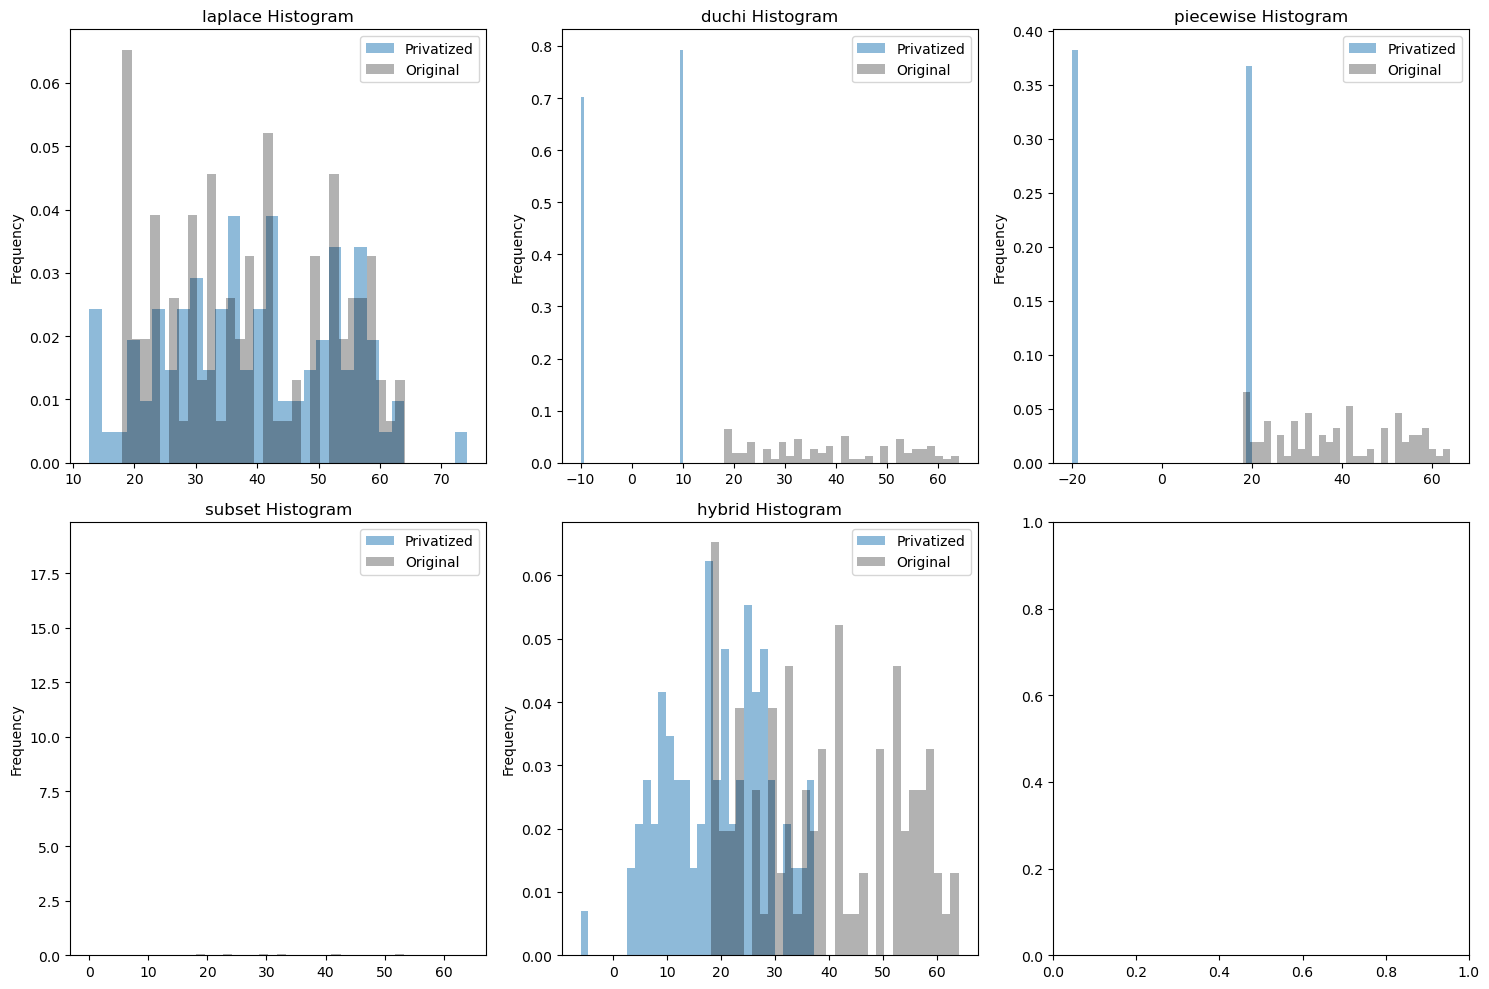

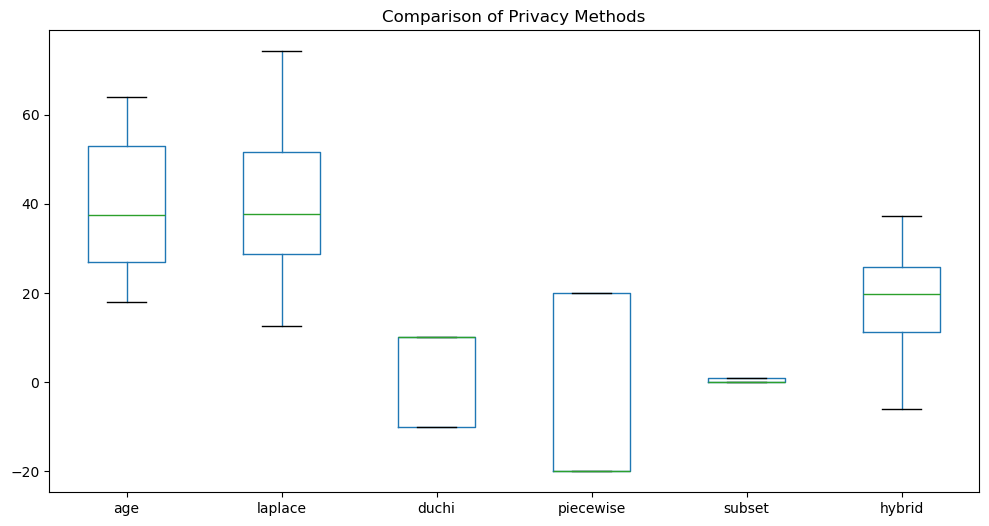

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame y que ya tiene una columna 'age'
epsilon = 0.2
df['laplace'] = apply_laplace(df['age'], epsilon)
df['duchi'] = apply_duchi(df['age'], epsilon)
df['piecewise'] = apply_piecewise(df['age'], epsilon)
df['subset'] = apply_subset_selection(df['age'], epsilon)
df['hybrid'] = apply_hybrid(df['age'], epsilon)

# Calculando MSE y MAE para cada método
metrics = pd.DataFrame(index=['MSE', 'MAE', 'Variance'], columns=df.columns[1:])
for method in metrics.columns:
    mse = np.mean((df['age'] - df[method])**2)
    mae = np.mean(np.abs(df['age'] - df[method]))
    var = np.var(df[method])
    metrics.at['MSE', method] = mse
    metrics.at['MAE', method] = mae
    metrics.at['Variance', method] = var

print(metrics)

# Visualización de histogramas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for ax, method in zip(axes, df.columns[1:]):
    df[method].plot(kind='hist', alpha=0.5, ax=ax, title=method + ' Histogram', density=True, bins=30)
    df['age'].plot(kind='hist', alpha=0.3, ax=ax, color='black', density=True, bins=30)
    ax.legend(['Privatized', 'Original'])

plt.tight_layout()
plt.show()

# Visualización de boxplots
df.boxplot(column=['age', 'laplace', 'duchi', 'piecewise', 'subset', 'hybrid'], grid=False, figsize=(12, 6))
plt.title('Comparison of Privacy Methods')
plt.show()
